# BT2101 Introduction to Linear Regression

#### Version: Python 3

## 1 Goal:

In this notebook, we will explore multiple linear regression using:
* Gradient descent method
* Open-source package: `scikit-learn`

For the gradient descent method, you will:
* Use numpy to write functions
* Write a derivative function
* Write an output function
* Write a gradient descent function
* Add a constant column of 1's as intercept term
* Use the gradient descent function to get regression estimators

In [31]:
# -*- coding:utf-8 -*-
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import sqrt
from __future__ import division
%matplotlib inline

### 1.1 Summary of Multiple Linear Regression

From the lecture class, we know that a typical linear regression model of *N* observations and *p* predictors:

\begin{align}
Y &= \beta_0 + \sum_{j=1}^p x_j \beta_j + \varepsilon \\
&= X\beta + \varepsilon 
\end{align}

And we aim to **Minimize** the loss function:

$$RSS(\beta) = \varepsilon^T\varepsilon = \sum_{i=1}^{N}(y_i - \beta_0 - \sum_{j=1}^p x_j \beta_j)^2 $$

Remember that the predicted output is calculated by the dot product of features and weights.<br/>
Suppose we have: <br/>
Two features: $x_i = [2.0, 1.5]$ <br/>
and Weights: $\beta = [1.0, 1.0]$ <br/>
Then the predicted output: $ \hat{y}_i = 1.0\times2.0 + 1.0\times1.5 = 3.5 $

In [32]:
def predict(feature_matrix, weight_vector):
    '''This function is used to predict outputs.
    
    Inputs:
    1) feature_matrix: A matrix of selected features;
    2) weight_vector: A vector of weights for selected features;
    
    Outputs:
    1) predict_vector: A vector of predicted outputs   
    
    '''
    
    prediction_vector = np.dot(feature_matrix, weight_vector)

    return prediction_vector

In [33]:
# Let us have a test
features = np.array([[2.0, 1.5], [4.8, 5.2]])
weights = np.ones((2, 1))
predict(features, weights)

array([[  3.5],
       [ 10. ]])

## 2 Gradient Descent
### 2.1 Computing Derivatives

How can we compute the derivatives of the loss function? <br/>
The loss function is calculated by summing up the squared errors over *N* data observations/rows:
$$RSS(\beta) = \sum_{i=1}^{N}(y_i - \beta_0 - \sum_{j=1}^p x_j \beta_j)^2 $$

Just doing simple math, you will find that the derivative of a sum equals to the sum of the derivatives. For a single observation *i*, the derivative with respect to feature $x_j$ for this observation *i* is $ -2\varepsilon_{i}x_{ij} $. So the derivative with respect to feature $x_j$ is $ -2\sum_{i=1}^N \varepsilon_{i}x_{ij} = -2\varepsilon^{T}x_j $. <br/>

In [34]:
def derivative(feature_matrix, error_vector):
    '''This function is used to calculate the derivatives for features.
    Inputs:
    1) feature_matrix: Data matrix of features (j = 0,...,p)
    2) error_vector: A vector of errors of N observations    
    
    Outputs:
    1) derive: Derivative for this feature j    
    
    '''
    
    derive = -2 * np.dot(feature_matrix.T, error_vector)
    
    return derive

In [35]:
# Let us have a test
features = np.array([[2.0, 1.0], [4.0, 3.0]])
weights = np.ones((2, 1))
true_outputs = np.array([[1.5], [2.5]])
predict_outputs = predict(features, weights)
errors = true_outputs - predict_outputs

print("True output is: \n%s " % true_outputs)
print ("Predicted output is: \n%s " % predict_outputs)
print ("Error is: \n%s " % errors)
print ("Derivative is: \n%s" % derivative(features, errors))

True output is: 
[[ 1.5]
 [ 2.5]] 
Predicted output is: 
[[ 3.]
 [ 7.]] 
Error is: 
[[-1.5]
 [-4.5]] 
Derivative is: 
[[ 42.]
 [ 30.]]


### 2.2 Procedures for Gradient Descent

Step 0: Initialize $ \beta = (\beta_{0},\dots,\beta_{p}) $; <br/>
Step 1: Calculate $ \beta_{j} \leftarrow \beta_{j} - Stepsize\times(-2\varepsilon^{T}x_j) $, for j = 1,...,p; <br/>
Step 2: If not converged, go back to Step 1; <br/>
Step 3: Get $ \beta $.

In [36]:
def OLS_GD(initial_weights, feature_matrix, true_output, step_size, tolerance, n_iter):
    '''This function is used to iteratively calculate OLS estimators for multiple regression model using Gradient Descent.
    Inputs:
    1) initial_weights: Initial regression coefficients
    2) feature_matrix: A matrix of selected features
    3) true_output: A vector of true outputs
    4) step_size: Size of step for each iteration of gradient search
    5) tolerance: Indicate converging condition
    6) n_iter: Maximum number of iterations
    
    Outputs:
    1) weights: OLS coefficients.    
    
    '''
    
    weights = np.array(initial_weights, dtype=np.float64)
    
    for i in range(n_iter):
        # Calculate predictions
        prediction = predict(feature_matrix, weights)
        
        # Calculate errors
        error = true_output - prediction
        
        # Calculating derivatives for weights
        derivative_vector = derivative(feature_matrix, error)
        
        # Updating weights
        weights -= step_size * derivative_vector        
        
        # Converging conditions: L2 norm for derivatives
        sum_squared_gradient = np.sum(np.power(derivative_vector,2))
        
        # If converging?
        if np.sqrt(sum_squared_gradient) < tolerance:
            return weights
    
    return weights


## 3 Convert Pandas DataFrame to Numpy Array

We need to: <br/>
1. Convert Pandas DataFrame into a Numpy Array/Matrix to do internal calculations;
2. Augment this Array/Matrix by adding 1's column in the first column, in order to calculate the intercept.

In [37]:
def convert_data(df, feature_names, output_name):
    '''This function is used to convert pandas dataframe to numpy array/matrix, and augment it with 1's column as intercept.
    Inputs:
    1) df: Original data in the format of pandas dataframe
    2) feature_names: A list of names of selected features
    3) output_name: Name of selected outputs
    
    Outputs:
    1) feature_matrix: Augmented feature matrix
    2) output_vector: A vector of true outputs    
    
    '''    
    
    # Feature names of Augmented matrix 
    augment_feature_names = ['intercept'] + feature_names
    
    # Augmented feature matrix by adding constant 1's as intercept term, and reorder the feature matrix
    df['intercept'] = 1 
    feature_matrix = df[augment_feature_names]
    n, k = feature_matrix.shape # n: number of observations; k: number of weights
    
    # Convert selected feature matrix and output vector to Numpy Array
    feature_matrix = feature_matrix.values.reshape((n, k))
    output_vector = df[output_name].values.reshape((n, 1))

    return (feature_matrix, output_vector)

## 4 Load Dataset and Conduct OLS Estimations

Our dataset can be obtained from [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Iris).

### 4.1 Attribute Information:

Attribute Information:

1. sepal length in cm 
2. sepal width in cm 
3. petal length in cm 
4. petal width in cm 
5. class: <br/>
-- Iris Setosa <br/>
-- Iris Versicolour <br/>
-- Iris Virginica


In [38]:
# Import dataset into Python Pandas DataFrame
filepath = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
colnames = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'class']
data = pd.read_csv(filepath, header=None, names=colnames, dtype={'sepal_length':np.float64, 'sepal_width':np.float64, 'petal_length':np.float64, 'petal_width':np.float64})
data.head(n=10)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
5,5.4,3.9,1.7,0.4,Iris-setosa
6,4.6,3.4,1.4,0.3,Iris-setosa
7,5.0,3.4,1.5,0.2,Iris-setosa
8,4.4,2.9,1.4,0.2,Iris-setosa
9,4.9,3.1,1.5,0.1,Iris-setosa


In [39]:
data.dropna() # Drop null values
data.describe()

,sepal_length,sepal_width,petal_length,petal_width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [40]:
# Select features and output:
# Suppose we want to use 'sepal_width' and 'petal_length' to predict 'sepal_length'

feature_list =  ['sepal_width', 'petal_length']
output_label = 'sepal_length'

features = convert_data(data, feature_list, output_label)[0]
output = convert_data(data, feature_list, output_label)[1]

In [41]:
features
output

array([[ 5.1],
       [ 4.9],
       [ 4.7],
       [ 4.6],
       [ 5. ],
       [ 5.4],
       [ 4.6],
       [ 5. ],
       [ 4.4],
       [ 4.9],
       [ 5.4],
       [ 4.8],
       [ 4.8],
       [ 4.3],
       [ 5.8],
       [ 5.7],
       [ 5.4],
       [ 5.1],
       [ 5.7],
       [ 5.1],
       [ 5.4],
       [ 5.1],
       [ 4.6],
       [ 5.1],
       [ 4.8],
       [ 5. ],
       [ 5. ],
       [ 5.2],
       [ 5.2],
       [ 4.7],
       [ 4.8],
       [ 5.4],
       [ 5.2],
       [ 5.5],
       [ 4.9],
       [ 5. ],
       [ 5.5],
       [ 4.9],
       [ 4.4],
       [ 5.1],
       [ 5. ],
       [ 4.5],
       [ 4.4],
       [ 5. ],
       [ 5.1],
       [ 4.8],
       [ 5.1],
       [ 4.6],
       [ 5.3],
       [ 5. ],
       [ 7. ],
       [ 6.4],
       [ 6.9],
       [ 5.5],
       [ 6.5],
       [ 5.7],
       [ 6.3],
       [ 4.9],
       [ 6.6],
       [ 5.2],
       [ 5. ],
       [ 5.9],
       [ 6. ],
       [ 6.1],
       [ 5.6],
       [ 6.7],
       [ 5

Now set up initial parameters and try gradient descent:

In [42]:
# Set up initial parameters
initial_weights = np.zeros((len(feature_list)+1, 1))
step_size = 7e-5 # Large step_size may lead to overflow
tolerance = 2e-9
iteration = 100000

In [43]:
# Try OLS with gradient descent
coefficients = OLS_GD(initial_weights, features, output, step_size, tolerance, iteration)
print ('Intercept ','X1', 'X2')
coefficients

Intercept  X1 X2


array([[ 2.25129459],
       [ 0.59675252],
       [ 0.47079369]])

You can try different `initial_weights`, `step_size`, `tolerance`, or `iteration`.<br/>
You can also use different features to run regression model. <br/>
Note that large step_size may lead to overflow issue. <br/>
Small tolerance may increase the number of iterations, but will result in more accurate estimators.

### 4.2 Compare with OLS Expression

Remember in the lecture class, we show the regression expression for OLS estimations:
$$ \beta = (X^{T}X)^{-1}X^{T}Y $$

In [44]:
def OLS_Expression(feature_matrix, true_output):
    '''This function is used to calculate OLS coefficients using standard expression.
    Inputs:
    1) feature_matrix: A matrix of selected features
    2) true_output: A vector of true outputs
        
    Outputs:
    1) weights: OLS coefficients
    
    '''
    
    XTX = np.dot(feature_matrix.T, feature_matrix)
    XTY = np.dot(feature_matrix.T, true_output)
    
    weights = np.dot(np.linalg.inv(XTX), XTY)
    
    return weights
    

In [45]:
coefficients = OLS_Expression(features, output)
print ('Intercept ','X1', 'X2')
coefficients

Intercept  X1 X2


array([[ 2.2512946 ],
       [ 0.59675252],
       [ 0.47079369]])

Compare OLS using gradient descent with OLS using expression. They are very close to each other.

## 5 Try Open-Source Package
### 5.1 Scikit-Learn
The package `scikit-learn` can be found at http://scikit-learn.org/stable/index.html. <br/>
Please install the package first.

In [46]:
from sklearn import linear_model

In [47]:
reg = linear_model.LinearRegression(fit_intercept=True)
reg.fit(X=data[feature_list], y=data[output_label])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [48]:
print (reg.intercept_, reg.coef_)

2.25129459509 [ 0.59675252  0.47079369]


Compare with OLS using gradient descent and OLS using expression. They are very close to each other.

Then we can calculate $ R^2 $, which measures goodness-of-fit of regression model.

In [49]:
print ('R_squared is: ', reg.score(X=data[feature_list], y=data[output_label]))

R_squared is:  0.840328864225


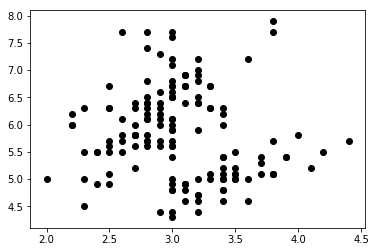

In [50]:
# Plot the relationship between 'sepal_width' and 'sepal_length'
plt.scatter(data[feature_list[0]], data[output_label], color='black')

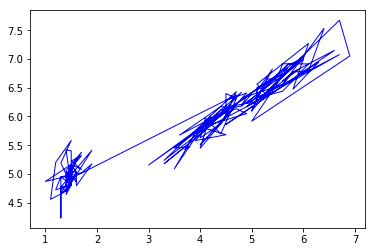

In [51]:
# Plot the relationship between 'petal_length' and 'sepal_length'
plt.plot(data[feature_list[1]], reg.predict(data[feature_list]), color='blue', linewidth=1)

More about Multiple Linear Regression can be found at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html.

## 6 References

[1] Jason Brownlee, 2018, [Machine Learning Algorithms from Scratch with Python](https://machinelearningmastery.com/machine-learning-algorithms-from-scratch/). <br/>
[2] Peter Harrington, 2012. Machine Learning in Action. Shelter Island, NY: Manning Publications Co.